In [1]:
import math
import dimod
import dwave_networkx as dnx
import dwave.inspector
import matplotlib.pyplot as plt
import minorminer
import networkx as nx
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite

In [3]:
topology_chimera = dnx.chimera_graph(16)
topology_pegasus = dnx.pegasus_graph(16)
topology_zephyr = dnx.zephyr_graph(15)

In [3]:
############### complete graphs ###############

In [40]:
# find chain diameter - average
C = dnx.chimera_graph(15)
n = 50
ns = np.arange(1, n+1)
m = 3

qubits_chimera = np.zeros_like(ns)
# qubits_chimera_clique = np.zeros_like(ns)

maxchain_chimera = np.zeros_like(ns)
# maxchain_chimera_clique = np.zeros_like(ns)

avg_chain_diameter = np.zeros(len(ns))

for i, n in enumerate(ns):
    G = nx.complete_graph(n)
    
    for j in range(m):
        embedding = minorminer.find_embedding(G, C)
        
        qubits_chimera[i] += sum(map(len, embedding.values()))
        maxchain_chimera[i] += max(map(len, embedding.values()))

        # calculate average chain diameter
        chain_diameters = np.zeros(len(embedding))
        
        for k, chain in enumerate(embedding.values()):
            if (len(chain) == 1):
                continue
                
            chain_edges = []
            
            for edge in C.edges:
                if edge[0] in chain and edge[1] in chain:
                    chain_edges.append(edge)
        
            E = nx.Graph(chain_edges)
            chain_diameters[k] = nx.diameter(E)

        avg_chain_diameter[i] += float(sum(chain_diameters) / len(chain_diameters))

    for tensor in [qubits_chimera, maxchain_chimera, avg_chain_diameter]:
        tensor[i] /= m

q = 4.291862301691025*x^2 + 1.333000242389877*x + 4.7398845821911175
[0.9996038481874362]


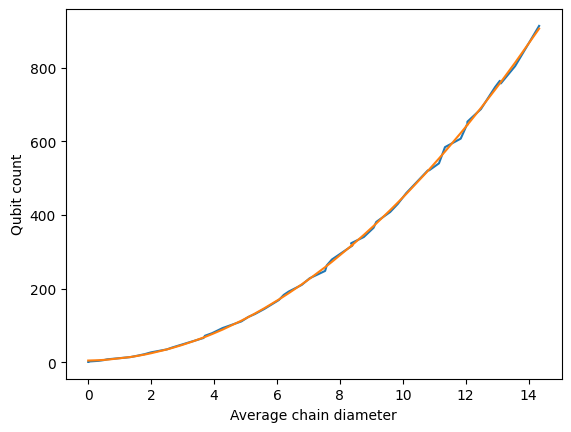

In [41]:
# plot chain diameter vs. #qubits
plt.plot(avg_chain_diameter, qubits_chimera)
# plt.plot(maxchain_chimera-1, qubits_chimera)
# plt.legend(["Average chain diameter", "Maximum chain length"])
plt.xlabel("Average chain diameter")
# plt.xlabel("Length")
plt.ylabel("Qubit count")

a, b, c = np.polyfit(avg_chain_diameter, qubits_chimera, 2)
chimera_fit = a*avg_chain_diameter*avg_chain_diameter + b*avg_chain_diameter + c
plt.plot(avg_chain_diameter, chimera_fit)
print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.savefig("qubits-complete-diameter-average.png")

In [31]:
# find chain diameter - scatter (MM)
C = dnx.chimera_graph(15)
n = 50
ns = np.arange(1, n+1)
m = 3

# 1 data point per embedding
qubits_chimera = np.zeros(m*len(ns))
avg_chain_diameter = np.zeros(m*len(ns))
max_chain_diameter = np.zeros(m*len(ns))

for i, n in enumerate(ns):
    G = nx.complete_graph(n)

    for j in range(m):
        embedding = minorminer.find_embedding(G, C)

        qubits_chimera[i*m+j] = sum(map(len, embedding.values()))

        # calculate average and max chain diameter
        chain_diameters = np.zeros(len(embedding))

        # construct graph of every qubit chain
        for k, chain in enumerate(embedding.values()):
            if (len(chain) == 1):
                continue
                
            chain_edges = []
            
            for edge in C.edges:
                if edge[0] in chain and edge[1] in chain:
                    chain_edges.append(edge)
        
            E = nx.Graph(chain_edges)
            chain_diameters[k] = nx.diameter(E)

        avg_chain_diameter[i*m+j] = float(sum(chain_diameters) / len(chain_diameters))
        max_chain_diameter[i*m+j] = max(chain_diameters)

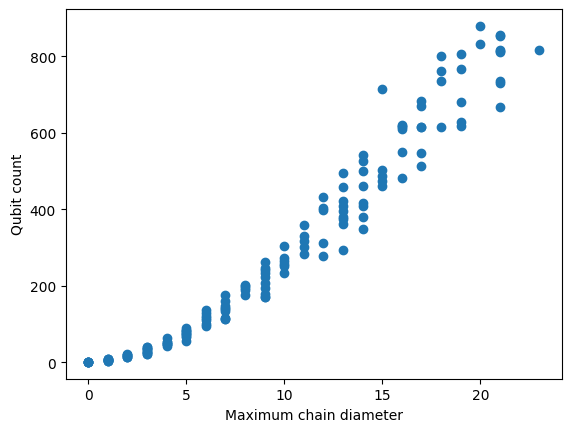

In [32]:
# plot chain diameter vs. #qubits - scatter (MM)

# plt.scatter(avg_chain_diameter, qubits_chimera)
plt.scatter(max_chain_diameter, qubits_chimera)
plt.xlabel("Maximum chain diameter")
plt.ylabel("Qubit count")
# plt.legend(["Average", "Maximum"])
do_fit = 0

if do_fit:
    # assume relationship is non-decreasing
    avg_chain_diameter_sorted = avg_chain_diameter
    qubits_chimera_sorted = qubits_chimera
    max_chain_diameter_sorted = max_chain_diameter
    
    avg_chain_diameter_sorted.sort()
    qubits_chimera_sorted.sort()
    max_chain_diameter_sorted.sort()
    
    a, b, c = np.polyfit(avg_chain_diameter_sorted, qubits_chimera_sorted, 2)
    avg_fit = a*avg_chain_diameter_sorted*avg_chain_diameter_sorted + b*avg_chain_diameter_sorted + c
    plt.plot(avg_chain_diameter_sorted, avg_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    a, b, c = np.polyfit(max_chain_diameter_sorted, qubits_chimera_sorted, 2)
    max_fit = a*max_chain_diameter_sorted*max_chain_diameter_sorted + b*max_chain_diameter_sorted + c
    plt.plot(max_chain_diameter_sorted, max_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    # test correlation
    corr_matrices = [np.corrcoef(qubits_chimera, avg_fit), np.corrcoef(qubits_chimera, max_fit)]
    corrs = [matrix[0,1] for matrix in corr_matrices]
    
    R_sq = [corr**2 for corr in corrs]
    print(R_sq)

plt.savefig("qubits-complete-max_diameter-qubits-mm.png")

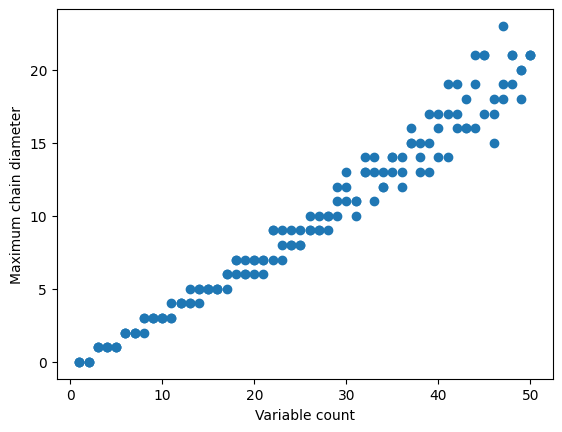

In [33]:
# plot #nodes vs. chain diameter - scatter (MM)
expanded_ns = np.zeros_like(max_chain_diameter) # np.zeros(m*len(ns))
for n in ns:
    for i in range(3):
        expanded_ns[3*(n-1)+i] = n

plt.scatter(expanded_ns, max_chain_diameter)
plt.xlabel("Variable count")
plt.ylabel("Maximum chain diameter")

do_fit = 0

if do_fit:
    # assume relationship is non-decreasing
    avg_chain_diameter_sorted = avg_chain_diameter
    qubits_chimera_sorted = qubits_chimera
    max_chain_diameter_sorted = max_chain_diameter
    
    avg_chain_diameter_sorted.sort()
    qubits_chimera_sorted.sort()
    max_chain_diameter_sorted.sort()
    
    a, b, c = np.polyfit(avg_chain_diameter_sorted, qubits_chimera_sorted, 2)
    avg_fit = a*avg_chain_diameter_sorted*avg_chain_diameter_sorted + b*avg_chain_diameter_sorted + c
    plt.plot(avg_chain_diameter_sorted, avg_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    a, b, c = np.polyfit(max_chain_diameter_sorted, qubits_chimera_sorted, 2)
    max_fit = a*max_chain_diameter_sorted*max_chain_diameter_sorted + b*max_chain_diameter_sorted + c
    plt.plot(max_chain_diameter_sorted, max_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    # test correlation
    corr_matrices = [np.corrcoef(qubits_chimera, avg_fit), np.corrcoef(qubits_chimera, max_fit)]
    corrs = [matrix[0,1] for matrix in corr_matrices]
    
    R_sq = [corr**2 for corr in corrs]
    print(R_sq)

plt.savefig("qubits-complete-n-max_diameter-mm.png")

In [27]:
# find chain diameter - scatter (clique)
C = dnx.chimera_graph(15)
n = 50
ns = np.arange(1, n+1)

qubits_chimera_clique = np.zeros(len(ns))
avg_chain_diameter_clique = np.zeros(len(ns))
max_chain_diameter_clique = np.zeros(len(ns))

for i, n in enumerate(ns):
    G = nx.complete_graph(n)

    embedding = minorminer.busclique.find_clique_embedding(n, C)
    qubits_chimera_clique[i] = sum(map(len, embedding.values()))

    # calculate average chain diameter
    chain_diameters = np.zeros(len(embedding))

    # find edges and construct qubit chain graph
    for k, chain in enumerate(embedding.values()):
        if (len(chain) == 1):
            continue
            
        chain_edges = []
        
        for edge in C.edges:
            if edge[0] in chain and edge[1] in chain:
                chain_edges.append(edge)
    
        E = nx.Graph(chain_edges)
        chain_diameters[k] = nx.diameter(E)

    avg_chain_diameter_clique[i] = float(sum(chain_diameters) / len(chain_diameters))
    max_chain_diameter_clique[i] = max(chain_diameters)

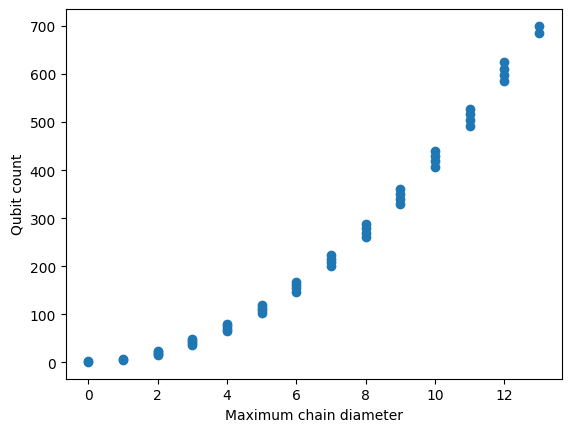

In [28]:
# plot chain diameter vs. #qubits - scatter (clique)

# plt.scatter(avg_chain_diameter_clique, qubits_chimera_clique)
plt.scatter(max_chain_diameter_clique, qubits_chimera_clique)
plt.xlabel("Maximum chain diameter")
plt.ylabel("Qubit count")
# plt.legend(["Average", "Maximum"])
do_fit = 0

if do_fit:
    # assume relationship is non-decreasing
    avg_chain_diameter_clique_sorted = avg_chain_diameter_clique
    qubits_chimera_clique_sorted = qubits_chimera_clique
    max_chain_diameter_clique_sorted = max_chain_diameter_clique
    
    avg_chain_diameter_clique_sorted.sort()
    qubits_chimera_clique_sorted.sort()
    max_chain_diameter_clique_sorted.sort()
    
    a, b, c = np.polyfit(avg_chain_diameter_clique_sorted, qubits_chimera_clique_sorted, 2)
    avg_fit = a*avg_chain_diameter_clique_sorted*avg_chain_diameter_clique_sorted + b*avg_chain_diameter_clique_sorted + c
    plt.plot(avg_chain_diameter_clique_sorted, avg_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    a, b, c = np.polyfit(max_chain_diameter_clique_sorted, qubits_chimera_clique_sorted, 2)
    max_fit = a*max_chain_diameter_clique_sorted*max_chain_diameter_clique_sorted + b*max_chain_diameter_clique_sorted + c
    plt.plot(max_chain_diameter_clique_sorted, max_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    # test correlation
    corr_matrices = [np.corrcoef(qubits_chimera_clique, avg_fit), np.corrcoef(qubits_chimera_clique, max_fit)]
    corrs = [matrix[0,1] for matrix in corr_matrices]
    
    R_sq = [corr**2 for corr in corrs]
    print(R_sq)

plt.savefig("qubits-complete-max_diameter-qubits-clique.png")

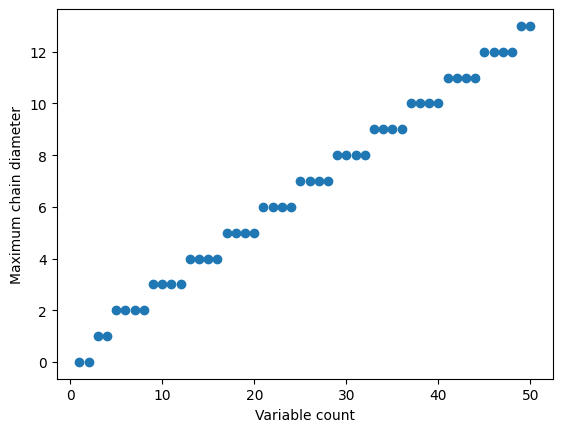

In [30]:
# plot #nodes vs. chain diameter - scatter (clique)
plt.scatter(ns, max_chain_diameter_clique)
plt.xlabel("Variable count")
plt.ylabel("Maximum chain diameter")

do_fit = 0

if do_fit:
    # assume relationship is non-decreasing
    avg_chain_diameter_clique_sorted = avg_chain_diameter_clique
    qubits_chimera_clique_sorted = qubits_chimera_clique
    max_chain_diameter_clique_sorted = max_chain_diameter_clique
    
    avg_chain_diameter_clique_sorted.sort()
    qubits_chimera_clique_sorted.sort()
    max_chain_diameter_clique_sorted.sort()
    
    a, b, c = np.polyfit(avg_chain_diameter_clique_sorted, qubits_chimera_clique_sorted, 2)
    avg_fit = a*avg_chain_diameter_clique_sorted*avg_chain_diameter_clique_sorted + b*avg_chain_diameter_clique_sorted + c
    plt.plot(avg_chain_diameter_clique_sorted, avg_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    a, b, c = np.polyfit(max_chain_diameter_clique_sorted, qubits_chimera_clique_sorted, 2)
    max_fit = a*max_chain_diameter_clique_sorted*max_chain_diameter_clique_sorted + b*max_chain_diameter_clique_sorted + c
    plt.plot(max_chain_diameter_clique_sorted, max_fit)
    print("q = " + str(a) + "*x^2 + " + str(b) + "*x + " + str(c))
    
    # test correlation
    corr_matrices = [np.corrcoef(qubits_chimera_clique, avg_fit), np.corrcoef(qubits_chimera_clique, max_fit)]
    corrs = [matrix[0,1] for matrix in corr_matrices]
    
    R_sq = [corr**2 for corr in corrs]
    print(R_sq)

plt.savefig("qubits-complete-n-max_diameter-clique.png")

In [ ]:
############## #nodes vs. #qubits ##############

In [42]:
# save data from all runs, not an average
m = 3
N = 61
ns = range(N)

qubits_chimera = np.zeros((m,N))
maxchain_chimera = np.zeros((m,N))
qubits_chimera_avg = np.zeros(N)
maxchain_chimera_avg = np.zeros(N)

for n in ns:
    if n==0:
        continue
        
    G = nx.complete_graph(n)
    
    for k in range(m):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[k][n] = sum(map(len, embedding.values()))
        maxchain_chimera[k][n] = max(map(len, embedding.values()))

        qubits_chimera_avg[n] += sum(map(len, embedding.values()))
        maxchain_chimera_avg[n] += max(map(len, embedding.values()))
        
    for tensor in [qubits_chimera_avg, maxchain_chimera_avg]:
        tensor[n] /= m

nqubits = 0.3612004927692977*nvars^2 + -0.9005506308502699*nvars + 5.0021740407780255


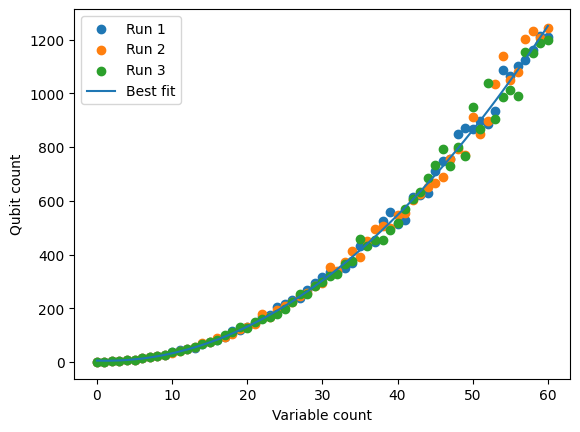

In [43]:
# plot runs as dots
leg = []
for k in range(m):
    plt.scatter(ns, qubits_chimera[k])
    leg.append("Run " + str(k+1))
leg.append("Best fit")

a, b, c = np.polyfit(ns, qubits_chimera_avg, 2)
chimera_fit = a*ns*ns + b*ns + c
plt.plot(ns, chimera_fit)
print("nqubits = " + str(a) + "*nvars^2 + " + str(b) + "*nvars + " + str(c))

plt.legend(leg)
plt.xlabel("Variable count")
plt.ylabel("Qubit count")

plt.savefig("qubits-complete-MM-fit.png")

In [ ]:
#### averages ####

In [ ]:
# complete graph, variable n vertices (MM, busclique) (Chimera, Pegasus, Zephyr)
ns = np.arange(1, 61)
m = 3

qubits_chimera = np.zeros_like(ns)
qubits_chimera_clique = np.zeros_like(ns)
qubits_pegasus = np.zeros_like(ns)
qubits_pegasus_clique = np.zeros_like(ns)
qubits_zephyr = np.zeros_like(ns)
qubits_zephyr_clique = np.zeros_like(ns)

maxchain_chimera = np.zeros_like(ns)
maxchain_chimera_clique = np.zeros_like(ns)
maxchain_pegasus = np.zeros_like(ns)
maxchain_pegasus_clique = np.zeros_like(ns)
maxchain_zephyr = np.zeros_like(ns)
maxchain_zephyr_clique = np.zeros_like(ns)

for i, n in enumerate(ns):
    G = nx.complete_graph(n)
    
    for j in range(m):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[i] += sum(map(len, embedding.values()))
        maxchain_chimera[i] += max(map(len, embedding.values()))
        
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[i] += sum(map(len, embedding.values()))
        maxchain_pegasus[i] += max(map(len, embedding.values()))

        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[i] += sum(map(len, embedding.values()))
        maxchain_zephyr[i] += max(map(len, embedding.values()))
        
    for tensor in [qubits_chimera, qubits_chimera_clique, qubits_pegasus, qubits_pegasus_clique, qubits_zephyr, qubits_zephyr_clique, maxchain_chimera, maxchain_chimera_clique, maxchain_pegasus, maxchain_pegasus_clique, maxchain_zephyr, maxchain_zephyr_clique]:
        tensor[i] /= m
        
    embedding = minorminer.busclique.find_clique_embedding(n, topology_chimera)
    qubits_chimera_clique[i] = sum(map(len, embedding.values()))
    maxchain_chimera_clique[i] = max(map(len, embedding.values()))
    
    embedding = minorminer.busclique.find_clique_embedding(n, topology_pegasus)
    qubits_pegasus_clique[i] = sum(map(len, embedding.values()))
    maxchain_pegasus_clique[i] = max(map(len, embedding.values()))

    embedding = minorminer.busclique.find_clique_embedding(n, topology_zephyr)
    qubits_zephyr_clique[i] = sum(map(len, embedding.values()))
    maxchain_zephyr_clique[i] = max(map(len, embedding.values()))
    
    # print(str(i) + " done")

Text(0, 0.5, 'Qubit count')

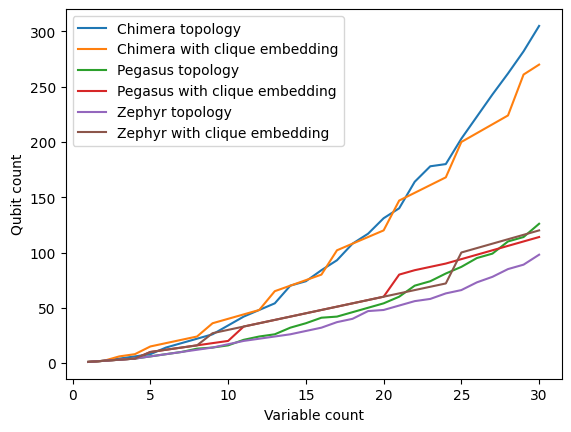

In [7]:
plt.plot(ns, qubits_chimera)
plt.plot(ns, qubits_chimera_clique)
plt.plot(ns, qubits_pegasus)
plt.plot(ns, qubits_pegasus_clique)
plt.plot(ns, qubits_zephyr)
plt.plot(ns, qubits_zephyr_clique)
plt.legend(["Chimera topology", "Chimera with clique embedding", "Pegasus topology", "Pegasus with clique embedding", "Zephyr topology", "Zephyr with clique embedding"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")
#plt.savefig("qubits-complete.png")

nqubits = 0.34630243921817816*avg_degree^2 + -0.48620987605273963*avg_degree + 2.9266009852215324
nqubits = 0.12622656125854095*avg_degree^2 + 0.27540819164151287*avg_degree + 1.448768472906352
nqubits = 0.07829632130939122*avg_degree^2 + 0.7959508580963002*avg_degree + 0.3197044334975096
[0.9988518998379677, 0.9983028780721745, 0.9979660006590182]


Text(0, 0.5, 'Qubit count')

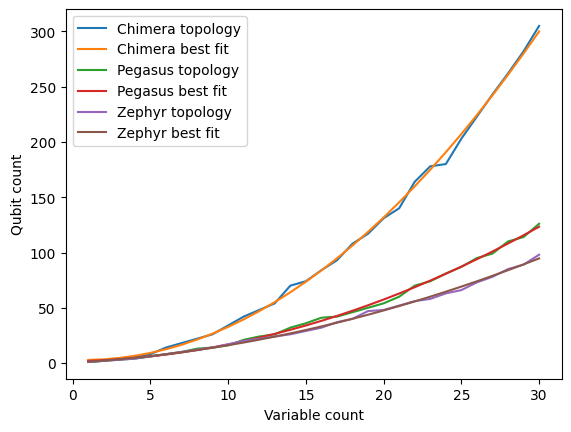

In [6]:
plt.plot(ns, qubits_chimera)
a, b, c = np.polyfit(ns, qubits_chimera, 2)
chimera_fit = a*ns*ns + b*ns + c
plt.plot(ns, chimera_fit)
print("nqubits = " + str(a) + "*nvars^2 + " + str(b) + "*nvars + " + str(c))

plt.plot(ns, qubits_pegasus)
a, b, c = np.polyfit(ns, qubits_pegasus, 2)
pegasus_fit = a*ns*ns + b*ns + c
plt.plot(ns, pegasus_fit)
print("nqubits = " + str(a) + "*nvars^2 + " + str(b) + "*nvars + " + str(c))

plt.plot(ns, qubits_zephyr)
a, b, c = np.polyfit(ns, qubits_zephyr, 2)
zephyr_fit = a*ns*ns + b*ns + c
plt.plot(ns, zephyr_fit)
print("nqubits = " + str(a) + "*nvars^2 + " + str(b) + "*nvars + " + str(c))

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit), np.corrcoef(qubits_pegasus, pegasus_fit), np.corrcoef(qubits_zephyr, zephyr_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.legend(["Chimera topology", "Chimera best fit", "Pegasus topology", "Pegasus best fit", "Zephyr topology", "Zephyr best fit"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")

plt.savefig("qubits-complete-MM-fit.png")

In [ ]:
#### clique fits ####

Text(0, 0.5, 'Qubit count')

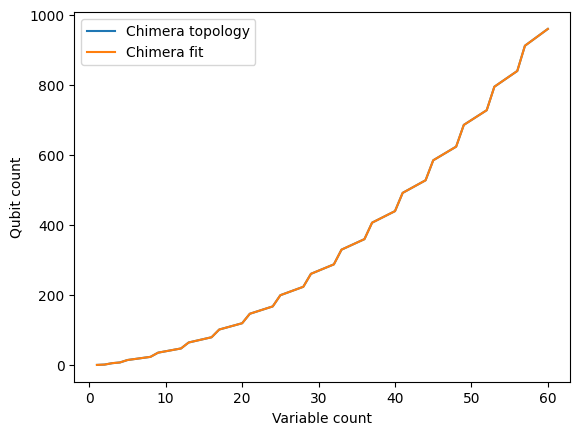

In [43]:
# ns = np.arange(1, 61)
chimera_fit = np.zeros_like(ns)

# initial value and special cases
chimera_fit[0] = 1
chimera_fit[1] = 2
chimera_fit[2] = 6
# pattern begins
for n in ns:
    n -= 1
    if (n<3): 
        continue
    if (n%4 >= 1): 
        chimera_fit[n] = chimera_fit[n-1] + math.ceil(n/4) + 1
    else:
        chimera_fit[n] = chimera_fit[n-1] + 5*math.floor(n/4) + 2

# plt.plot(ns, qubits_chimera_clique)
# plt.plot(ns, chimera_fit)

# plt.legend(["Chimera topology", "Chimera fit"])
# plt.xlabel("Variable count")
# plt.ylabel("Qubit count")

#plt.savefig("qubits-complete-C-clique-fit.png")

Qubits required: 8


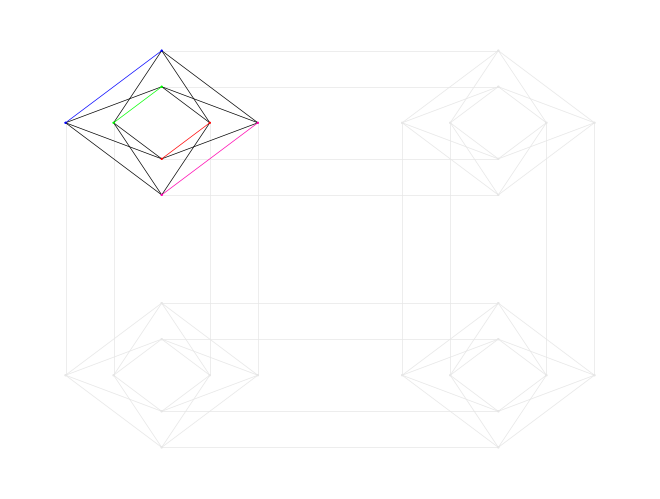

In [6]:
C = dnx.chimera_graph(2)
n = 4  # max 64 for C(16)
emb_C = minorminer.busclique.find_clique_embedding(n, C)
print("Qubits required: " + str(sum(map(len, emb_C.values()))))
dnx.draw_chimera_embedding(
    C, 
    emb_C,
    show_labels=False,
    node_shape='.',
    width=0.5,
    node_size=1
)

Text(0, 0.5, 'Qubit count')

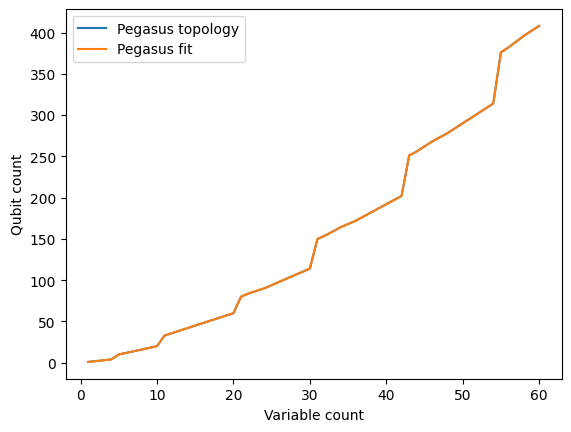

In [44]:
# ns = np.arange(1. 61)
pegasus_fit = np.zeros_like(ns)
i = 4  # tracks round number

for n in ns:
    n -= 1

    # initial value and special cases
    if n < 1:
        pegasus_fit[n] = 1
    elif n < 4:
        pegasus_fit[n] = pegasus_fit[n-1] + 1
    elif n < 5:
        pegasus_fit[n] = pegasus_fit[n-1] + 6
    elif n < 10:
        pegasus_fit[n] = pegasus_fit[n-1] + 2
    elif n < 11:
        pegasus_fit[n] = pegasus_fit[n-1] + 13
    elif n < 20:
        pegasus_fit[n] = pegasus_fit[n-1] + 3
    elif n < 21:
        pegasus_fit[n] = pegasus_fit[n-1] + 20
    elif n < 22:
        pegasus_fit[n] = pegasus_fit[n-1] + 4
    elif n < 24:
        pegasus_fit[n] = pegasus_fit[n-1] + 3

    # pattern begins
    elif (n)%12 < 6:
        pegasus_fit[n] = pegasus_fit[n-1] + i
    elif (n)%12 < 7:
        pegasus_fit[n] = pegasus_fit[n-1] + 13*i - 16
    elif (n)%12 < 8:
        pegasus_fit[n] = pegasus_fit[n-1] + i
    elif (n)%12 < 10:
        pegasus_fit[n] = pegasus_fit[n-1] + i + 1
    else: 
        pegasus_fit[n] = pegasus_fit[n-1] + i
        if n%12 == 11:
            i += 1

plt.plot(ns, qubits_pegasus_clique)
plt.plot(ns, pegasus_fit)

plt.legend(["Pegasus topology", "Pegasus fit"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")
#plt.savefig("qubits-complete-P-clique-fit.png")

Qubits required: 57


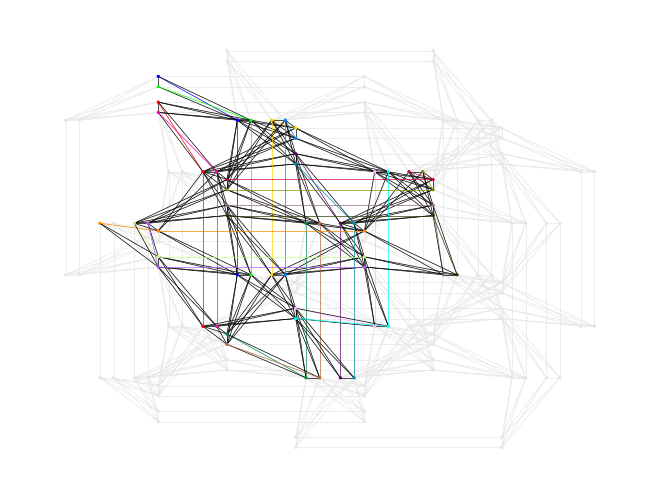

In [40]:
P = dnx.pegasus_graph(3)
n = 19  # max 180 for P(16)
emb_P = minorminer.busclique.find_clique_embedding(n, P)
print("Qubits required: " + str(sum(map(len, emb_P.values()))))
dnx.draw_pegasus_embedding(
    P, 
    emb_P,
    show_labels=False,
    node_shape='.',
    width=0.5,
    node_size=5
)

Text(0, 0.5, 'Qubit count')

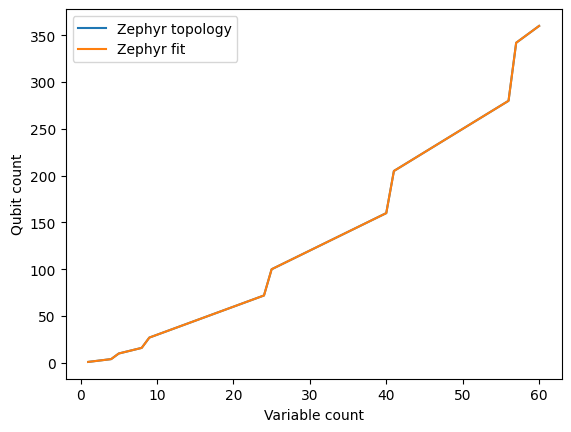

In [6]:
# ns = np.arange(1, 13*17 + 11 + 1)
zephyr_fit = np.zeros_like(ns)
zephyr_fit[0] = 1  # initial value

for n in ns:
    n -= 1
    if n==0:
        continue
        
    # phase 1
    if n<9:
        if n%4 > 0: 
            zephyr_fit[n] = zephyr_fit[n-1] + math.ceil(n/4)
        else:
            zephyr_fit[n] = zephyr_fit[n-1] + 5*math.ceil(n/4) + 1
    # phase 2
    else:
        if (n-8)%16 > 0: 
            zephyr_fit[n] = zephyr_fit[n-1] + math.ceil((n-8)/16) + 2
        else:
            zephyr_fit[n] = zephyr_fit[n-1] + 17*math.ceil((n-8)/16) + 11

plt.plot(ns, qubits_zephyr_clique)
plt.plot(ns, zephyr_fit)
# print("Max qubits required: " + str(zephyr_fit[-1]))

plt.legend(["Zephyr topology", "Zephyr fit"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")
#plt.savefig("qubits-complete-Z-clique-fit.png")

Qubits required: 205


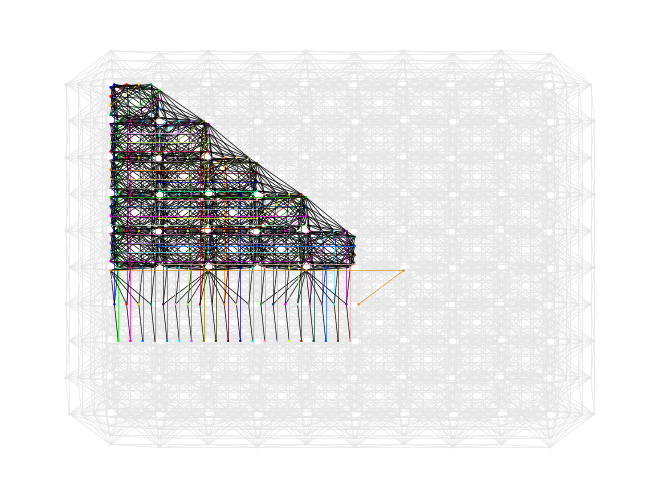

In [9]:
Z = dnx.zephyr_graph(5)
n = 41  # max 13*17 + 11 for Z(15)
emb_Z = minorminer.busclique.find_clique_embedding(n, Z)
print("Qubits required: " + str(sum(map(len, emb_Z.values()))))
dnx.draw_zephyr_embedding(
    Z, 
    emb_Z,
    show_labels=False,
    node_shape='.',
    width=0.5,
    node_size=1
)
# Z: big jump after every row (4*(row + row-1 + ...) = sum(range(1, row, 1)))

In [ ]:
# plot all buscliques
plt.plot(ns, qubits_chimera_clique)
plt.plot(ns, qubits_pegasus_clique)
plt.plot(ns, qubits_zephyr_clique)

plt.title("Qubits required for busclique embeddings")
plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.xlabel("Variable count")
plt.ylabel("Qubit count")

plt.savefig("qubits-complete-clique.png")

In [ ]:
# find slope of clique embedding segment
st=56
end=61

arr = qubits_zephyr_clique[st:end]
lil_ns = ns[st:end]
plt.plot(lil_ns, arr)
a, b = np.polyfit(lil_ns, arr, 1)
zephyr_fit = a*lil_ns + b
print(a)
plt.plot(lil_ns, zephyr_fit)

Text(0, 0.5, 'Maximum chain length')

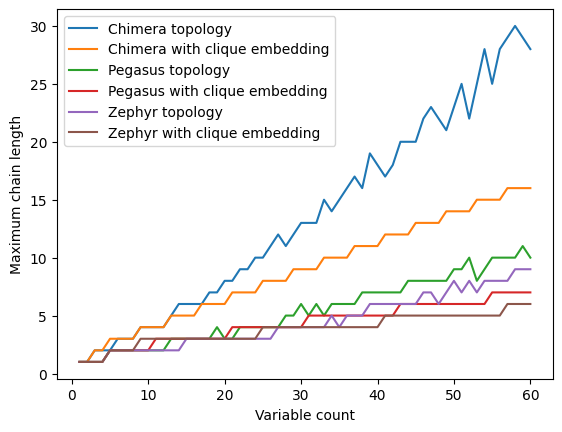

In [7]:
# MM maxchain
plt.plot(ns, maxchain_chimera)
plt.plot(ns, maxchain_pegasus)
plt.plot(ns, maxchain_zephyr)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.xlabel("Variable count")
plt.ylabel("Maximum chain length")

plt.savefig("qubits-complete-maxchain-mm.png")

Text(0, 0.5, 'Maximum chain length')

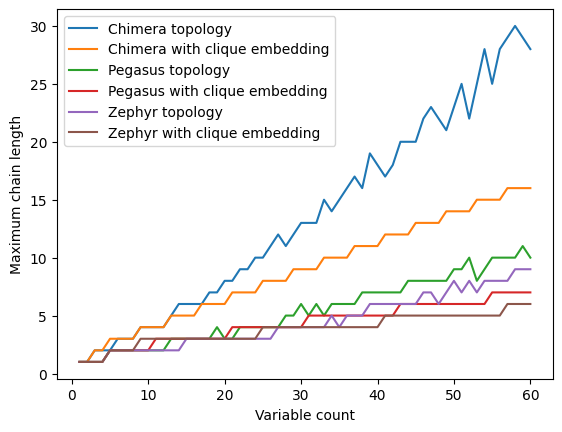

In [7]:
# busclique maxchain
plt.plot(ns, maxchain_chimera_clique)
plt.plot(ns, maxchain_pegasus_clique)
plt.plot(ns, maxchain_zephyr_clique)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.xlabel("Variable count")
plt.ylabel("Maximum chain length")

plt.savefig("qubits-complete-maxchain-clique.png")